# Distracted Driver Detection



# 图像分类

在该项目中，我将会对来自走神司机数据集(https://www.kaggle.com/c/state-farm-distracted-driver-detection/data) 中的图像进行分类。数据集中图片的内容包括司机的10中状态。我需要处理这些图像，训练一个卷积神经网络对他们进行分类。

## 观察数据

引入OpenCV库读取图片数据。展示样例图片，并大致观察一下数据的分布。

In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow'
import keras

Using TensorFlow backend.


In [2]:
import numpy as np
np.random.seed(2017)

import os
import glob
import cv2
import math
import pickle
import datetime
import pandas as pd
import random
import time
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss


D:\conda\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
import zipfile, os
z = zipfile.ZipFile('imgs.zip')
z.extractall()
z.close()

In [3]:
# Load a small normalized grayscale image
def get_im_cv2(path, img_size):
    img = cv2.imread(path)
    img = np.array(img, dtype=np.uint8)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # reduce size
    img = cv2.resize(img, (img_size, img_size))

    # subtract the mean
    img[:, :, 0] -= 104
    img[:, :, 1] -= 117
    img[:, :, 2] -= 124
    # rescale
    #img = 2 * (img - np.min(img))/(np.max(img) - np.min(img)) -1
    return img

In [4]:
# Load a random augmented image
def get_im_cv2_aug(path, img_size):
    img = cv2.imread(path)
    img = np.array(img, dtype=np.uint8)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #random rotate and scale
    rotate = random.uniform(-10, 10)
    z = random.uniform(0.8, 1.2)
    M1 = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), rotate, 1)
    img = cv2.warpAffine(img, M1, (img.shape[1], img.shape[0]))
    
    #random shift
    tx = random.uniform(-50, 50)
    ty = random.uniform(-30, 50)
    M2 = np.float32([[1,0,tx],[0,1,0]])
    img = cv2.warpAffine(img, M2, (img.shape[1], img.shape[0]))
    
    # reduce size
    img = cv2.resize(img, (img_size, img_size))
    
    # random flip
    #f = random.choice([-1, 0, 1, 2])
    #img = cv2.flip(img, f)
    
    # subtract the mean
    img[:, :, 0] -= 104
    img[:, :, 1] -= 117
    img[:, :, 2] -= 124

    return img

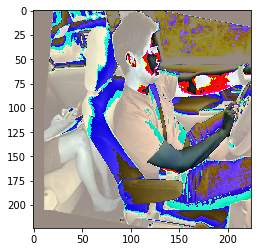

In [5]:
%matplotlib inline
path = os.path.join('.', 'train', 'c0', 'img_1078.jpg')

plt.imshow(get_im_cv2_aug(path, 224))

/opt/anaconda3/envs/mlnd-dl/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


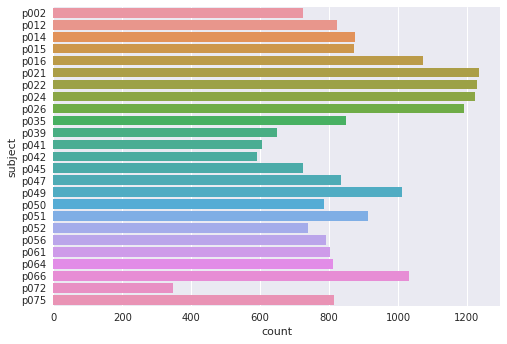

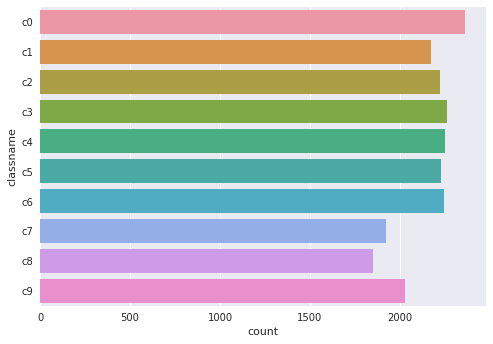

In [6]:
import seaborn as sns
sns.set(style="darkgrid")
drivers = pd.read_csv(os.path.join('.', 'driver_imgs_list_right.csv'))
#print(drivers['classname'][1])

plt.figure(1)
ax1 = sns.countplot(y="subject", data=drivers)

plt.figure(2)
ax2 = sns.countplot(y="classname", data=drivers)

## 切分数据

按照司机的id来切分训练数据集。把driver_imgs_list分成两个列表。一个是训练列表，里面是所有训练集司机的图片文件名。另一个是验证列表，里面是所有验证集司机的图片文件名。然后把两个列表都随机打乱。

In [7]:
# divide drivers
unique_list_train = ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051']
unique_list_valid = ['p072', 'p075', 'p081', 'p066', 'p052', 'p056', 'p061', 'p064']

# get index: driver_id, class, image name
index = os.path.join('.', 'driver_imgs_list_right.csv')

# split the driver list
f = open(index, 'r')
train_list = []
valid_list = []
lines = f.readlines()
#print (lines[1], lines[2])
for line in lines[1:]:
    arr = line.strip().split(',')
    if arr[0] in unique_list_train:
        train_list.append(line)
    elif arr[0] in unique_list_valid:
        valid_list.append(line)
f.close()
random.shuffle(train_list)
random.shuffle(valid_list)

print (len(train_list), len(valid_list))

(16202, 5340)


In [3]:
test_index = os.path.join('.', 'sample_submission.csv')
f = open(test_index, 'r')
lines = f.readlines()
test_list = []
for line in lines[1:]:
    arr = line.strip().split(',')
    test_list.append(arr[0])
f.close()
print (test_list[:5])

['img_1.jpg', 'img_10.jpg', 'img_100.jpg', 'img_1000.jpg', 'img_100000.jpg']


## 转换为One Hot Encode标签

对标签进行One Hot Encode的函数如下。

In [4]:
# one hot encode the class label

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])   
def one_hot_encode(x):
    return lb.transform(x)
t = one_hot_encode(['c1', 'c2'])
print(t)

[[0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]


## 迁移学习1

第一种迁移学习方法，在预训练模型后面挂自己写的分类器，仅训练这个分类器。首先定义图片的生成器。分为训练图片，从训练列表中遍历。以及验证图片，从验证列表里遍历。

In [10]:
# define my train data generator
def train_gen(batch_size):
    current = 0
    while 1:
        x = []
        y = []
        while len(y) < batch_size:
            line = train_list[current]
            arr = line.strip().split(',')
            path = os.path.join('.', 'train', str(arr[1]), str(arr[2]))
            #print (path)
            img = get_im_cv2_aug(path, 224)
            x.append(img)
            label = one_hot_encode([str(arr[1])])[0]
            y.append(label)
            current += 1
            if current >= len(train_list):
                current = 0
        x = np.array(x)
        x = x.reshape(batch_size, img_size, img_size, 3) 
        y = np.array(y, dtype = np.uint32)
        y = y.reshape(batch_size, 10)
        yield (x, y)

In [11]:
# define my validation data generator

def valid_gen(batch_size):
    current = 0
    while 1:
        x = []
        y = []
        while len(y) < batch_size:
            line = valid_list[current]
            arr = line.strip().split(',')
            path = os.path.join('.', 'train', str(arr[1]), str(arr[2]))
            #print (path)
            img = get_im_cv2(path, 224)
            x.append(img)
            label = one_hot_encode([str(arr[1])])[0]
            y.append(label)
            current += 1
            if current >= len(valid_list):
                current = 0
        x = np.array(x)
        x = x.reshape(batch_size, img_size, img_size, 3) 
        y = np.array(y, dtype = np.uint32)
        y = y.reshape(batch_size, 10)
        yield (x, y)

## 迁移学习1

构建模型并训练。

In [12]:
# new model

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *


img_size = 224
x = Input((img_size, img_size, 3))
base_model = ResNet50(input_tensor = x, weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)
model = Model(base_model.input, x)
#model.summary()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [ ]:
# train the model

hist = model.fit_generator(train_gen(64), steps_per_epoch = 508, epochs = 10, validation_data = valid_gen(64), validation_steps = 84)

Epoch 1/10
507/508 [============================>.] - ETA: 0s - loss: 1.1501 - categorical_accuracy: 0.7198  

## 迁移学习1

保存模型。输出history数据，观察loss曲线。

In [17]:
from keras.models import load_model

# save the models
model.save('my_model.h5')

{'val_categorical_accuracy': [0.3984375, 0.4068080357142857, 0.42596726190476192, 0.38039434523809523, 0.39713541666666669, 0.40513392857142855, 0.37741815476190477, 0.41387648809523808, 0.39527529761904762, 0.38764880952380953], 'loss': [1.228157230718868, 1.2152487585159737, 1.2056618085292381, 1.2098887681843729, 1.2128806491419086, 1.2045504076509026, 1.2103522937950186, 1.2075200122524434, 1.2121577525702047, 1.2116417979278902], 'categorical_accuracy': [0.69168307086614178, 0.69860359251968507, 0.70337106299212604, 0.69860359251968507, 0.69869586614173229, 0.70038754921259838, 0.69848056102362199, 0.70115649606299213, 0.69666584645669294, 0.69888041338582674], 'val_loss': [2.0615944954611005, 2.0458735213393258, 1.9783892936649776, 2.0431222475710369, 1.9867108528103148, 2.0279559585310163, 2.0893864425874891, 2.0040950157812665, 2.0427002949374065, 2.0672329706805095]}


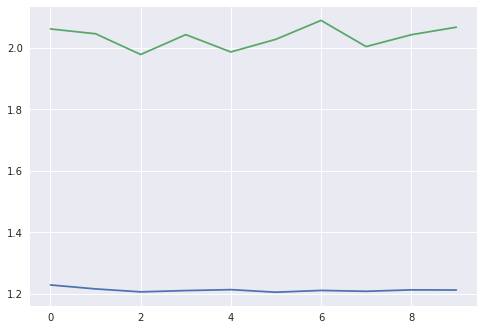

In [16]:
print (hist.history)
plt.figure(1)
plt.plot (hist.history['loss'])
plt.plot (hist.history['val_loss'])

## 迁移学习1

载入模型。对test数据进行预测，将结果写入csv文件。这里没有使用生成器。

In [5]:
# load the model
from keras.models import load_model  
model = load_model('my_model.h5')

D:\conda\envs\tensorflow\lib\site-packages\keras\models.py:281: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [27]:
# define my test data generator
test_index = os.path.join('.', 'sample_submission.csv')
def test_gen(batch_size):
    f = open(test_index, 'r')
    lines = f.readline()
    while 1:
        x = []
        while len(x) < batch_size:
            line = f.readline()
            if line == '':
                break
            arr = line.strip().split(',')
            path = os.path.join('.', 'test', str(arr[0]))
            #print (path)
            img = get_im_cv2(path)
            x.append(img)
        l = len(x)    
        x = np.array(x, dtype = np.float32)
        x = x.reshape(l, img_size, img_size, 3)
        print (x.size)
        yield x
    f.close()

In [9]:
path = os.path.join('.', 'test', '*.jpg')
files = glob.glob(path)

img_size = 224
test_prediction = []
test_id = []

for f in tqdm(files):
    fbase = os.path.basename(f)
    img = get_im_cv2(f, 224)
    img = img.reshape(1, img_size, img_size, 3)
    #print (fbase)
    test_prediction.append(model.predict(img, batch_size = 1)[0])
    test_id.append(fbase)
    
result = pd.DataFrame(test_prediction, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
result.insert(0, 'img', pd.Series(test_id, index=result.index))
result.to_csv(os.path.join('.' ,'my_submission.csv'), index=False)

  0%|                                                                             | 69/79726 [00:22<6:48:38,  3.25it/s]

KeyboardInterrupt: 

## 迁移学习2

第二种迁移学习方法，用预训练模型算出所有图片的特征向量并保存。然后把特征向量用分类器训练分类。
首先把不同司机存放在一个字典里，键为id，值为一条记录，包含了图片名和类别信息。

In [5]:
# divide drivers by 26 different ids
unique_list_train = ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051']
unique_list_valid = ['p072', 'p075', 'p081', 'p066', 'p052', 'p056', 'p061', 'p064']

# get index: driver_id, class, image name
index = os.path.join('.', 'driver_imgs_list_right.csv')

# split the driver list
f = open(index, 'r')
id = dict()
lines = f.readlines()

for line in lines[1:]:
    arr = line.strip().split(',')
    if arr[0] not in id.keys():
        id[arr[0]] = [line]
    else:
        id[arr[0]].append(line)
f.close()
#id.pop('p081')

#test the length
len_id = 0
for k in id.keys():
    print (len(id[k]))
    len_id +=len(id[k])
print (len_id)

913
814
346
1072
604
792
1011
804
1228
848
740
724
875
873
822
590
1234
784
811
1193
1033
834
649
724
1224
21542


定义图片读取函数，根据不同的模型，进行相应的预处理。

In [21]:
# Load a preprocessed image according to different models
def get_im_cv2_mod(path, mod):
    img = cv2.imread(path)
    if mod is (InceptionV3 or Xception):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (299, 299))
    else:
        img = cv2.resize(img, (224, 224))
        img[:, :, 0] -= 104
        img[:, :, 1] -= 117
        img[:, :, 2] -= 124

    return img

定义训练集的特征向量计算函数。从司机列表里按照给定的id获取一位司机的训练集图片，用predict_on_batch方法进行预测，返回训练集图片的特征向量和类别。

In [27]:
# define a driver's feature vector

def driver_gap(model, img_size, nb_last, mod, driver_id):
    driver_list = id[driver_id]
    l = len(driver_list)
    driver_x = np.zeros((l, nb_last))
    driver_y = []
    current = 0
    ind = 0
    batch_size = 64
    print ('Reading driver %s feature vector...'%driver_id)
    while current < l:
        x = []
        while len(x) < batch_size:
            line = driver_list[current]
            arr = line.strip().split(',')
            path = os.path.join('.', 'train', str(arr[1]), str(arr[2]))
            img = get_im_cv2_mod(path, mod)
            x.append(img)
            driver_y.append(arr[1].encode('utf8'))
            #print (driver_y)
            current += 1
            if current >= l:
                break
        nb = len(x)
        x = np.array(x, dtype = np.float32)
        x = x.reshape(nb, img_size, img_size, 3) 
        pred = model.predict_on_batch(x)
        driver_x[ind:ind + batch_size, :] = pred
        ind += batch_size
        print (1.0 * ind / l)

    return driver_x, driver_y

## 迁移学习2

定义测试集的特征向量计算函数。从验测试列表里获取一个批次的训练集图片名称，用predict_on_batch方法进行预测，返回测试集图片的特征向量。

In [28]:
# define my test data feature vector

def test_gap(model, img_size, nb_last, mod):

    l = len(test_list)
    #print (l)
    test_x = np.zeros((l, nb_last))
    current = 0
    ind = 0
    batch_size = 64
    print ('Reading test set feature vector...')
    while current < l:
        x = []
        while len(x) < batch_size:
            line = test_list[current]
            path = os.path.join('.', 'test', str(line))
            #print (path)
            img = get_im_cv2_mod(path, mod)
            x.append(img)
            current += 1
            if current >= l:
                break
        nb = len(x)
        x = np.array(x, dtype = np.float32)
        x = x.reshape(nb, img_size, img_size, 3) 
        pred = model.predict_on_batch(x)
        #print (ind + batch_size, pred.shape)
        test_x[ind:ind + batch_size, :] = pred
        ind += batch_size
        print (1.0* ind / l)

    return test_x

## 迁移学习2

根据选用的预训练模型，设定模型名称，最后一层输出维度，图片尺寸。调用特征向量计算函数进行计算。最后把训练集不同司机的特征向量和类别，验证集特征向量都写入一个h5py文件。

In [39]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import h5py

def write_gap(mod):
    # select the pre-trained model
    if mod == InceptionV3:
        img_size = 299
        x = Input((img_size, img_size, 3))
        x = Lambda(inception_v3.preprocess_input)(x)
        nb_last = 2048
    elif mod == Xception:
        img_size = 299
        x = Input((img_size, img_size, 3))
        x = Lambda(xception.preprocess_input)(x)
        nb_last = 2048
    elif mod == ResNet50:
        img_size = 224
        x = Input((img_size, img_size, 3))
        nb_last = 2048
    else:
        img_size = 224
        x = Input((img_size, img_size, 3))
        nb_last = 512
    # build the model
    base_model = mod(input_tensor = x, weights='imagenet', include_top=False)
    y = GlobalAveragePooling2D()(base_model.output)
    model = Model(base_model.input, y)
    
    #use the model to predict, and write into the h5py file
    f = h5py.File('gap_%s.h5'%mod.__name__, 'w')
    for k in id.keys():
        driver_x, driver_y = driver_gap(model, img_size, nb_last, mod, k)
        f.create_dataset('%s_x'%k, data = driver_x)
        f.create_dataset('%s_y'%k, data = driver_y)
    test_x = test_gap(model, img_size, nb_last, mod)
    f.create_dataset('test_x', data = test_x)

In [40]:
write_gap(VGG16)

Reading driver p022 feature vector...
0.0260586319218
0.0521172638436
0.0781758957655
0.104234527687
0.130293159609
0.156351791531
0.182410423453
0.208469055375
0.234527687296
0.260586319218
0.28664495114
0.312703583062
0.338762214984
0.364820846906
0.390879478827
0.416938110749
0.442996742671
0.469055374593
0.495114006515
0.521172638436
0.547231270358
0.57328990228
0.599348534202
0.625407166124
0.651465798046
0.677524429967
0.703583061889
0.729641693811
0.755700325733
0.781758957655
0.807817589577
0.833876221498
0.85993485342
0.885993485342
0.912052117264
0.938110749186
0.964169381107
0.990228013029
1.01628664495
Reading driver p049 feature vector...
0.0316518298714
0.0633036597428
0.0949554896142
0.126607319486
0.158259149357
0.189910979228
0.2215628091
0.253214638971
0.284866468843
0.316518298714
0.348170128586
0.379821958457
0.411473788328
0.4431256182
0.474777448071
0.506429277943
0.538081107814
0.569732937685
0.601384767557
0.633036597428
0.6646884273
0.696340257171
0.72799208704

KeyboardInterrupt: 

## 迁移学习2

从h5py文件中读取。

In [7]:
import h5py

h = h5py.File('gap_ResNet50.h5', 'r')
print (h['p021_x'].shape, h['p075_y'].shape, h['test_x'].shape)
h.close()

(1234, 2048) (814,) (79726, 2048)


In [7]:
feature_vec = dict()
label = dict()

for gap in ['gap1_InceptionV3.h5', 'gap1_ResNet50.h5', 'gap1_VGG16.h5']:
    f = h5py.File(gap, 'r')
    for k in tqdm(id.keys()): 
        if k not in feature_vec.keys():
            feature_vec[k] = [np.array(f['%s_x'%k])]
        else:
            feature_vec[k].append(np.array(f['%s_x'%k]))
        if k not in label.keys():
            label[k] = one_hot_encode(f['%s_y'%k][::].astype(str))
    #test_merged.append(np.array(f['test_x']))
    f.close()
            
#print('Feature Vector Shape for Model #0:', train_merged[0].shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.40it/s]


In [8]:
feature_merged = dict()
for k in tqdm(feature_vec.keys()):
     feature_merged[k] = np.concatenate(feature_vec[k], axis=1)

#X_test = np.concatenate(test_merged, axis=1)
print('Feature Vector Shape after Merging all 3 models:', feature_merged['p021'].shape, label['p021'].shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 62.46it/s]


Feature Vector Shape after Merging all 3 models: (1237, 4608) (1237, 10)


In [11]:
from keras.models import *
from keras.layers import *

inputs = Input((feature_merged['p021'].shape[1],))
x = Dropout(0.5)(inputs)
#x = Dense(100, activation='relu')(x)
y = Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)

model_fusion = Model(inputs=inputs, outputs=y, name='Fusion')
model_fusion.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['categorical_accuracy'])
model_fusion.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 4608)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                46090     
Total params: 46,090
Trainable params: 46,090
Non-trainable params: 0
_________________________________________________________________


In [19]:
# knn cannot converge
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)

In [10]:
# svm cannot converge
from sklearn.svm import SVC
#from sklearn.multiclass import OneVsRestClassifier
clf = SVC(C=0.1, probability=True)

In [28]:
# Random Forest loss=2
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0)

In [ ]:
kf = KFold(n_splits=5)
driver_list = ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p072', 'p075', 'p066', 'p052', 'p056', 'p061', 'p064']
sum_score = 0
score_list = []
for train_index, valid_index in tqdm(kf.split(driver_list)):
    train_list = []
    train_label = []
    valid_list = []
    valid_label = []
    score = 0
    train_driver = [driver_list[d] for d in train_index]
    valid_driver = [driver_list[d] for d in valid_index]
    for d in driver_list:
        if d in train_driver:
            train_list.append(feature_merged[d])
            train_label.append(label[d])
        else:
            valid_list.append(feature_merged[d])
            valid_label.append(label[d])
    train_feature_merged = np.concatenate(train_list, axis=0)
    train_label_merged = np.concatenate(train_label, axis=0)
    nb_train = train_label_merged.shape[0]
    valid_feature_merged = np.concatenate(valid_list, axis=0)
    valid_label_merged = np.concatenate(valid_label, axis=0)
    
    #model_fusion.fit(x=train_feature_merged, y=train_label_merged, batch_size=128, epochs=30, shuffle=True, validation_data=(valid_feature_merged, valid_label_merged))
    #pred_valid = model_fusion.predict(valid_feature_merged, batch_size=128)
    clf.fit(train_feature_merged, np.argmax(train_label_merged, axis=1))
    pred_valid = clf.predict_proba(valid_feature_merged)
    #print (pred_valid[3])
    score = log_loss(valid_label_merged, pred_valid)
    #print (score)
    score_list.append(score)
    sum_score += score * valid_label_merged.shape[0]
    
print ('mean log loss is: ', sum_score/21542)

0it [00:00, ?it/s]

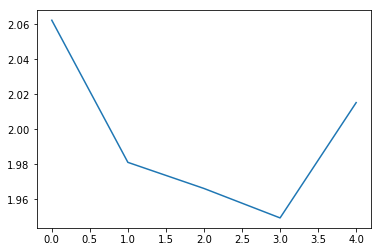

In [30]:
#print(score_list)
%matplotlib inline
plt.figure(1)
plt.plot (score_list)

In [ ]:
test_feature = []

for gap in tqdm(['gap1_InceptionV3.h5', 'gap1_ResNet50.h5', 'gap1_VGG16.h5']):
    f = h5py.File(gap, 'r')
    test_feature.append(np.array(f['test_x']))
    f.close()
    
test_merged = np.concatenate(test_feature, axis=1)

print('Feature Vector Shape after Merging all 3 models:', test_merged.shape)

 33%|████████████████████████████                                                        | 1/3 [00:17<00:34, 17.09s/it]

In [32]:
#test_pred = model_fusion.predict(test_merged, batch_size=128)
test_pred = clf.predict_proba(test_merged)
test_pred = test_pred.clip(min=0.005, max=0.995)
    
result = pd.DataFrame(test_pred, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
result.insert(0, 'img', pd.Series(test_list, index=result.index))
result.to_csv(os.path.join('.' ,'my_submission2.csv'), index=False)

In [12]:
# Load a preprocessed image according to different models, augmented
def get_im_cv2_mod_aug(path, mod):
    img = cv2.imread(path)
    
    #random rotate and scale
    rotate = random.uniform(-10, 10)
    M1 = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), rotate, 1)
    img = cv2.warpAffine(img, M1, (img.shape[1], img.shape[0]))
    
    #random shift
    tx = random.uniform(-50, 50)
    ty = random.uniform(-30, 50)
    M2 = np.float32([[1,0,tx],[0,1,0]])
    img = cv2.warpAffine(img, M2, (img.shape[1], img.shape[0]))
    
    if mod is (InceptionV3 or Xception):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (299, 299))
    else:
        img = cv2.resize(img, (224, 224))
        img[:, :, 0] -= 104
        img[:, :, 1] -= 117
        img[:, :, 2] -= 124

    return img

In [41]:
# define a driver's feature vector including augment

def driver_gap_aug(model, img_size, nb_last, mod, driver_id):
    driver_list = id[driver_id] + id[driver_id] # double the driver_list for image augmentation
    l = len(driver_list)
    driver_x = np.zeros((l, nb_last))
    driver_y = []
    current = 0
    ind = 0
    batch_size = 64
    print ('Reading driver %s feature vector...'%driver_id)
    while current < l:
        x = []
        while len(x) < batch_size:
            line = driver_list[current]
            arr = line.strip().split(',')
            path = os.path.join('.', 'train', str(arr[1]), str(arr[2]))
            img = get_im_cv2_mod_aug(path, mod)
            x.append(img)
            driver_y.append(arr[1].encode('utf8'))
            #print (driver_y)
            current += 1
            if current >= l:
                break
        nb = len(x)
        x = np.array(x, dtype = np.float32)
        x = x.reshape(nb, img_size, img_size, 3) 
        pred = model.predict_on_batch(x)
        driver_x[ind:ind + batch_size, :] = pred
        ind += batch_size
        print (1.0 * ind / l)

    return driver_x, driver_y

In [42]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import h5py

def write_gap_aug(mod):
    # select the pre-trained model
    if mod == InceptionV3:
        img_size = 299
        x = Input((img_size, img_size, 3))
        x = Lambda(inception_v3.preprocess_input)(x)
        nb_last = 2048
    elif mod == Xception:
        img_size = 299
        x = Input((img_size, img_size, 3))
        x = Lambda(xception.preprocess_input)(x)
        nb_last = 2048
    elif mod == ResNet50:
        img_size = 224
        x = Input((img_size, img_size, 3))
        nb_last = 2048
    else:
        img_size = 224
        x = Input((img_size, img_size, 3))
        nb_last = 512
    # build the model
    base_model = mod(input_tensor = x, weights='imagenet', include_top=False)
    y = GlobalAveragePooling2D()(base_model.output)
    model = Model(base_model.input, y)
    
    #use the model to predict, and write into the h5py file
    f = h5py.File('gap_aug_%s.h5'%mod.__name__, 'w')
    for k in id.keys():
        driver_x, driver_y = driver_gap_aug(model, img_size, nb_last, mod, k)
        f.create_dataset('%s_x'%k, data = driver_x)
        f.create_dataset('%s_y'%k, data = driver_y)
    #test_x = test_gap(model, img_size, nb_last, mod)
    #f.create_dataset('test_x', data = test_x)

In [45]:
write_gap_aug(InceptionV3)

Reading driver p022 feature vector...
0.0260586319218
0.0521172638436
0.0781758957655
0.104234527687
0.130293159609
0.156351791531
0.182410423453
0.208469055375
0.234527687296
0.260586319218
0.28664495114
0.312703583062
0.338762214984
0.364820846906
0.390879478827
0.416938110749
0.442996742671
0.469055374593
0.495114006515
0.521172638436
0.547231270358
0.57328990228
0.599348534202
0.625407166124
0.651465798046
0.677524429967
0.703583061889
0.729641693811
0.755700325733
0.781758957655
0.807817589577
0.833876221498
0.85993485342
0.885993485342
0.912052117264
0.938110749186
0.964169381107
0.990228013029
1.01628664495
Reading driver p049 feature vector...
0.0316518298714
0.0633036597428
0.0949554896142
0.126607319486
0.158259149357
0.189910979228
0.2215628091
0.253214638971
0.284866468843
0.316518298714
0.348170128586
0.379821958457
0.411473788328
0.4431256182
0.474777448071
0.506429277943
0.538081107814
0.569732937685
0.601384767557
0.633036597428
0.6646884273
0.696340257171
0.72799208704

In [7]:
import h5py

h = h5py.File('gap_aug_ResNet50.h5', 'r')
print (h['p021_x'].shape, h['p075_y'].shape)
h.close()

(2468, 2048) (1628,)


In [8]:
feature_vec = dict()
label = dict()

for gap in ['gap_aug_InceptionV3.h5', 'gap_aug_ResNet50.h5', 'gap_aug_VGG16.h5']:
    f = h5py.File(gap, 'r')
    for k in tqdm(id.keys()): 
        if k not in feature_vec.keys():
            feature_vec[k] = [np.array(f['%s_x'%k])]
        else:
            feature_vec[k].append(np.array(f['%s_x'%k]))
        if k not in label.keys():
            label[k] = one_hot_encode(f['%s_y'%k][::].astype(str))
    #test_merged.append(np.array(f['test_x']))
    f.close()
            
#print('Feature Vector Shape for Model #0:', train_merged[0].shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  7.65it/s]


In [9]:
feature_merged = dict()
for k in tqdm(feature_vec.keys()):
     feature_merged[k] = np.concatenate(feature_vec[k], axis=1)

#X_test = np.concatenate(test_merged, axis=1)
print('Feature Vector Shape after Merging all 3 models:', feature_merged['p021'].shape, label['p021'].shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 27.40it/s]


Feature Vector Shape after Merging all 3 models: (2468, 4608) (2468, 10)


In [ ]:
kf = KFold(n_splits=5)
driver_list = ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p072', 'p075', 'p066', 'p052', 'p056', 'p061', 'p064']
sum_score = 0
score_list = []
for train_index, valid_index in tqdm(kf.split(driver_list)):
    train_list = []
    train_label = []
    valid_list = []
    valid_label = []
    score = 0
    train_driver = [driver_list[d] for d in train_index]
    valid_driver = [driver_list[d] for d in valid_index]
    for d in driver_list:
        if d in train_driver:
            train_list.append(feature_merged[d])
            train_label.append(label[d])
        else:
            valid_list.append(feature_merged[d])
            valid_label.append(label[d])
    train_feature_merged = np.concatenate(train_list, axis=0)
    train_label_merged = np.concatenate(train_label, axis=0)
    nb_train = train_label_merged.shape[0]
    valid_feature_merged = np.concatenate(valid_list, axis=0)
    valid_label_merged = np.concatenate(valid_label, axis=0)
    
    model_fusion.fit(x=train_feature_merged, y=train_label_merged, batch_size=128, epochs=20, shuffle=True, validation_data=(valid_feature_merged, valid_label_merged))
    pred_valid = model_fusion.predict(valid_feature_merged, batch_size=128)
    #clf.fit(train_feature_merged, np.argmax(train_label_merged, axis=1))
    #pred_valid = clf.predict_proba(valid_feature_merged)
    #print (pred_valid[3])
    score = log_loss(valid_label_merged, pred_valid)
    #print (score)
    score_list.append(score)
    sum_score += score * valid_label_merged.shape[0]
    
print ('mean log loss is: ', sum_score/21542)

0it [00:00, ?it/s]

Train on 34352 samples, validate on 8732 samples
Epoch 1/20
34352/34352 [==============================] - ETA: 509s - loss: 10.0930 - categorical_accuracy: 0.078 - ETA: 269s - loss: 9.0179 - categorical_accuracy: 0.105 - ETA: 109s - loss: 8.1814 - categorical_accuracy: 0.09 - ETA: 79s - loss: 8.0072 - categorical_accuracy: 0.1060 - ETA: 56s - loss: 7.8415 - categorical_accuracy: 0.105 - ETA: 44s - loss: 7.7529 - categorical_accuracy: 0.098 - ETA: 36s - loss: 7.5829 - categorical_accuracy: 0.102 - ETA: 30s - loss: 7.5149 - categorical_accuracy: 0.103 - ETA: 27s - loss: 7.3835 - categorical_accuracy: 0.106 - ETA: 24s - loss: 7.2746 - categorical_accuracy: 0.114 - ETA: 22s - loss: 7.2069 - categorical_accuracy: 0.114 - ETA: 21s - loss: 7.1442 - categorical_accuracy: 0.116 - ETA: 20s - loss: 7.1005 - categorical_accuracy: 0.117 - ETA: 18s - loss: 7.0217 - categorical_accuracy: 0.120 - ETA: 17s - loss: 6.9500 - categorical_accuracy: 0.122 - ETA: 16s - loss: 6.8511 - categorical_accuracy: 0

34352/34352 [==============================] - ETA: 5s - loss: 0.8741 - categorical_accuracy: 0.75 - ETA: 4s - loss: 0.8949 - categorical_accuracy: 0.76 - ETA: 4s - loss: 0.9229 - categorical_accuracy: 0.76 - ETA: 4s - loss: 0.9672 - categorical_accuracy: 0.74 - ETA: 4s - loss: 0.9869 - categorical_accuracy: 0.73 - ETA: 4s - loss: 0.9833 - categorical_accuracy: 0.74 - ETA: 4s - loss: 0.9586 - categorical_accuracy: 0.74 - ETA: 4s - loss: 0.9527 - categorical_accuracy: 0.74 - ETA: 4s - loss: 0.9444 - categorical_accuracy: 0.74 - ETA: 4s - loss: 0.9449 - categorical_accuracy: 0.74 - ETA: 4s - loss: 0.9375 - categorical_accuracy: 0.75 - ETA: 4s - loss: 0.9358 - categorical_accuracy: 0.75 - ETA: 4s - loss: 0.9412 - categorical_accuracy: 0.74 - ETA: 4s - loss: 0.9446 - categorical_accuracy: 0.75 - ETA: 3s - loss: 0.9461 - categorical_accuracy: 0.75 - ETA: 3s - loss: 0.9448 - categorical_accuracy: 0.75 - ETA: 3s - loss: 0.9476 - categorical_accuracy: 0.75 - ETA: 3s - loss: 0.9449 - categorica

34352/34352 [==============================] - ETA: 4s - loss: 0.6300 - categorical_accuracy: 0.85 - ETA: 4s - loss: 0.6666 - categorical_accuracy: 0.83 - ETA: 4s - loss: 0.6913 - categorical_accuracy: 0.83 - ETA: 4s - loss: 0.6920 - categorical_accuracy: 0.83 - ETA: 4s - loss: 0.7143 - categorical_accuracy: 0.82 - ETA: 4s - loss: 0.7134 - categorical_accuracy: 0.82 - ETA: 4s - loss: 0.7200 - categorical_accuracy: 0.82 - ETA: 4s - loss: 0.7169 - categorical_accuracy: 0.82 - ETA: 4s - loss: 0.7140 - categorical_accuracy: 0.82 - ETA: 4s - loss: 0.7135 - categorical_accuracy: 0.82 - ETA: 4s - loss: 0.7100 - categorical_accuracy: 0.82 - ETA: 3s - loss: 0.7125 - categorical_accuracy: 0.82 - ETA: 3s - loss: 0.7090 - categorical_accuracy: 0.82 - ETA: 3s - loss: 0.7085 - categorical_accuracy: 0.82 - ETA: 3s - loss: 0.7006 - categorical_accuracy: 0.83 - ETA: 3s - loss: 0.6974 - categorical_accuracy: 0.83 - ETA: 3s - loss: 0.6926 - categorical_accuracy: 0.83 - ETA: 3s - loss: 0.6953 - categorica

34352/34352 [==============================] - ETA: 4s - loss: 0.5687 - categorical_accuracy: 0.89 - ETA: 4s - loss: 0.5843 - categorical_accuracy: 0.88 - ETA: 4s - loss: 0.6433 - categorical_accuracy: 0.85 - ETA: 4s - loss: 0.6520 - categorical_accuracy: 0.85 - ETA: 4s - loss: 0.6408 - categorical_accuracy: 0.85 - ETA: 4s - loss: 0.6415 - categorical_accuracy: 0.85 - ETA: 4s - loss: 0.6487 - categorical_accuracy: 0.85 - ETA: 3s - loss: 0.6540 - categorical_accuracy: 0.85 - ETA: 3s - loss: 0.6628 - categorical_accuracy: 0.84 - ETA: 3s - loss: 0.6579 - categorical_accuracy: 0.84 - ETA: 3s - loss: 0.6576 - categorical_accuracy: 0.85 - ETA: 3s - loss: 0.6565 - categorical_accuracy: 0.85 - ETA: 3s - loss: 0.6492 - categorical_accuracy: 0.85 - ETA: 3s - loss: 0.6462 - categorical_accuracy: 0.85 - ETA: 3s - loss: 0.6440 - categorical_accuracy: 0.85 - ETA: 3s - loss: 0.6418 - categorical_accuracy: 0.85 - ETA: 3s - loss: 0.6439 - categorical_accuracy: 0.85 - ETA: 3s - loss: 0.6433 - categorica

34352/34352 [==============================] - ETA: 4s - loss: 0.7179 - categorical_accuracy: 0.85 - ETA: 4s - loss: 0.6664 - categorical_accuracy: 0.84 - ETA: 4s - loss: 0.6730 - categorical_accuracy: 0.83 - ETA: 4s - loss: 0.6574 - categorical_accuracy: 0.84 - ETA: 4s - loss: 0.6336 - categorical_accuracy: 0.85 - ETA: 4s - loss: 0.6193 - categorical_accuracy: 0.86 - ETA: 4s - loss: 0.6312 - categorical_accuracy: 0.85 - ETA: 4s - loss: 0.6254 - categorical_accuracy: 0.85 - ETA: 4s - loss: 0.6229 - categorical_accuracy: 0.85 - ETA: 4s - loss: 0.6199 - categorical_accuracy: 0.86 - ETA: 4s - loss: 0.6199 - categorical_accuracy: 0.86 - ETA: 3s - loss: 0.6167 - categorical_accuracy: 0.86 - ETA: 3s - loss: 0.6196 - categorical_accuracy: 0.86 - ETA: 3s - loss: 0.6252 - categorical_accuracy: 0.85 - ETA: 3s - loss: 0.6267 - categorical_accuracy: 0.85 - ETA: 3s - loss: 0.6266 - categorical_accuracy: 0.85 - ETA: 3s - loss: 0.6233 - categorical_accuracy: 0.85 - ETA: 3s - loss: 0.6236 - categorica

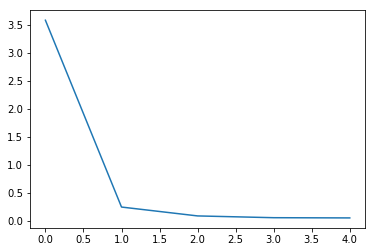

In [14]:
#print(score_list)
%matplotlib inline
plt.figure(1)
plt.plot (score_list)

In [15]:
del feature_vec, feature_merged, label, id

In [16]:
test_feature = []

for gap in tqdm(['gap1_InceptionV3.h5', 'gap1_ResNet50.h5', 'gap1_VGG16.h5']):
    f = h5py.File(gap, 'r')
    test_feature.append(np.array(f['test_x']))
    f.close()
    
test_merged = np.concatenate(test_feature, axis=1)

print('Feature Vector Shape after Merging all 3 models:', test_merged.shape)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:50<00:00, 28.55s/it]


Feature Vector Shape after Merging all 3 models: (79726, 4608)


In [16]:
test_pred = model_fusion.predict(test_merged, batch_size=128)
#test_pred = clf.predict_proba(test_merged)
test_pred = test_pred.clip(min=0.005, max=0.995)
    
result = pd.DataFrame(test_pred, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
result.insert(0, 'img', pd.Series(test_list, index=result.index))
result.to_csv(os.path.join('.' ,'my_submission2.csv'), index=False)